[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hesther/rxn_workshop/blob/main/workshop_solution.ipynb)

# GCNNs for molecules and reactions

Welcome to the workshop! This is the complete notebook containing solutions and comments. If you instead want to follow along with a near-empty notebook, open the workshop_exercise.ipynb instead.

Let's install and import all packages we will need

In [4]:
!pip install -q rdkit numpy scikit-learn chemprop torch==2.0.1
!pip install -q torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
!pip install -q torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.1/504.1 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
from rdkit import Chem
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

import torch_geometric as tg
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_add_pool

from sklearn.metrics import mean_absolute_error, mean_squared_error

The following cell contains some pre-made functions to obtain atom and bond features. You can always customize these functions or use entirely different ones.

In [6]:
def atom_features(atom):
    features = onek_encoding_unk(atom.GetSymbol(), ['H', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'Br', 'I']) + \
        onek_encoding_unk(atom.GetTotalDegree(), [0, 1, 2, 3, 4, 5]) + \
        onek_encoding_unk(atom.GetFormalCharge(), [-1, -2, 1, 2, 0]) + \
        onek_encoding_unk(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4]) + \
        onek_encoding_unk(int(atom.GetHybridization()),[Chem.rdchem.HybridizationType.SP,
                                                        Chem.rdchem.HybridizationType.SP2,
                                                        Chem.rdchem.HybridizationType.SP3,
                                                        Chem.rdchem.HybridizationType.SP3D,
                                                        Chem.rdchem.HybridizationType.SP3D2
                                                        ]) + \
        [1 if atom.GetIsAromatic() else 0] + \
        [atom.GetMass() * 0.01]
    return features

def bond_features(bond):
    bond_fdim = 7

    if bond is None:
        fbond = [1] + [0] * (bond_fdim - 1)
    else:
        bt = bond.GetBondType()
        fbond = [
            0,  # bond is not None
            bt == Chem.rdchem.BondType.SINGLE,
            bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE,
            bt == Chem.rdchem.BondType.AROMATIC,
            (bond.GetIsConjugated() if bt is not None else 0),
            (bond.IsInRing() if bt is not None else 0)
        ]
    return fbond

def onek_encoding_unk(value, choices):
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1
    return encoding

def make_mol(smi):
    params = Chem.SmilesParserParams()
    params.removeHs = False
    return Chem.MolFromSmiles(smi,params)

Let's inspect some molecules and make features for them:

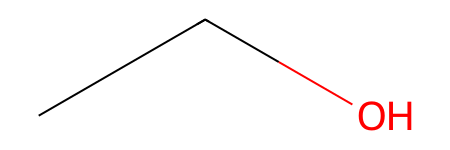

In [8]:
m=make_mol("CCO")
m

In [14]:
for a in m.GetAtoms():
  print(atom_features(a))

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.12011]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.12011]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.15999000000000002]


In [15]:
for b in m.GetBonds():
  print(bond_features(b))

[0, True, False, False, False, False, False]
[0, True, False, False, False, False, False]


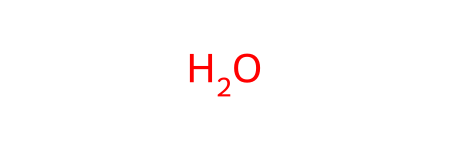

In [16]:
make_mol("O")

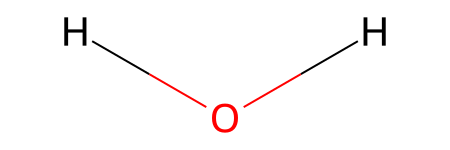

In [17]:
make_mol("[H][O][H]")

# Molecular graph
We now need to transform our RDKit molecule objects to graphs with edge (bond) and node (atom) features. Here, we use a simply one-hot encoding of symbol, degree, formal charge, hydrogen atoms, hybridization, aromaticity and mass for the atoms (vector size = 39). For bond features, we simply use whether a bond is not None (important later), the bond type, and whether it is conjugated and in a ring (vector size = 7). In general, this initial featurization should be adapted for more complex problems.

In [18]:
class MolGraph:
    def __init__(self, smiles):
        self.smiles = smiles
        self.f_atoms = []
        self.f_bonds = []
        self.edge_index = []

        mol = make_mol(self.smiles)
        n_atoms=mol.GetNumAtoms()

        for a1 in range(n_atoms):
            f_atom = atom_features(mol.GetAtomWithIdx(a1))
            self.f_atoms.append(f_atom)

            for a2 in range(a1 + 1, n_atoms):
                bond = mol.GetBondBetweenAtoms(a1, a2)
                if bond is None:
                    continue
                f_bond = bond_features(bond)
                self.f_bonds.append(f_bond)
                self.f_bonds.append(f_bond)
                self.edge_index.extend([(a1, a2), (a2, a1)])

In [20]:
g = MolGraph("CCO")
for i,f in enumerate(g.f_atoms):
  print(i,f)
for (i,j),f in zip(g.edge_index,g.f_bonds):
  print(i,j,f)

0 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.12011]
1 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.12011]
2 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.15999000000000002]
0 1 [0, True, False, False, False, False, False]
1 0 [0, True, False, False, False, False, False]
1 2 [0, True, False, False, False, False, False]
2 1 [0, True, False, False, False, False, False]


For a dataset of molecules and their properties, we can now build a dataset object, and a loader which inherit from pytorch_geometric's `Dataset` and `DataLoader`. The `ChemDataset` class takes as input a list of SMILES and target values. Whenever we retrieve an element from this list via the `get()` function, we create a `MolGraph` from the respective SMILES strings. For this course, we do not implement any caching, but remake the graphs whenever we need them (we also don't hold them in memory). The `molgraph2data` function transforms our custom `MolGraph` into a format more convenient for pytorch_geometric's functionalities (and, importantly, into torch tensors). The `construct_loader()` functions takes a CSV file saved locally or from the internet, and uses the first column as list of SMILES, and the second as list of targets, for the sake of simplicity (for a real software package, don't hardcode this!)

In [21]:
class ChemDataset(Dataset):
    def __init__(self, smiles, labels, mode='mol'):
        super(ChemDataset, self).__init__()
        self.smiles = smiles
        self.labels = labels
        self.mode = mode

    def process_key(self, key):
        smi = self.smiles[key]
        if self.mode == 'mol':
            molgraph = MolGraph(smi)
        else:
            raise ValueError("Unknown option for mode", mode)
        mol = self.molgraph2data(molgraph, key)
        return mol

    def molgraph2data(self, molgraph, key):
        data = tg.data.Data()
        data.x = torch.tensor(molgraph.f_atoms, dtype=torch.float)
        data.edge_index = torch.tensor(molgraph.edge_index, dtype=torch.long).t().contiguous()
        data.edge_attr = torch.tensor(molgraph.f_bonds, dtype=torch.float)
        data.y = torch.tensor([self.labels[key]], dtype=torch.float)
        data.smiles = self.smiles[key]
        return data

    def get(self,key):
        return self.process_key(key)

    def len(self):
        return len(self.smiles)

def construct_loader(data_path, shuffle=True, batch_size=50, mode='mol'):
    data_df = pd.read_csv(data_path)
    smiles = data_df.iloc[:, 0].values
    labels = data_df.iloc[:, 1].values.astype(np.float32)
    dataset = ChemDataset(smiles, labels, mode)
    loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=0,
                            pin_memory=True,
                            sampler=None)
    return loader

Let's inspect a dataset. For each batch, we get a list of SMILES strings, node features, edge features and connectivity lists. Note that the format is a bit unintuitive: SMILES, node features and labels are lists or lists of list of `len(data)`, but the edge features and attributes are a single list for the full data chunk:

In [22]:
loader = construct_loader("https://github.com/hesther/rxn_workshop/raw/main/data/esol/train_full.csv")
for data in loader:
    print(data)
    print("SMILES",data.smiles[:3])
    print("node features",data.x[:3])
    print("labels",data.y[:3])
    print("edges",data.edge_index[:,:10])
    print("edge features",data.edge_attr[:10])
    break

DataBatch(x=[679, 39], edge_index=[2, 1400], edge_attr=[1400, 7], y=[50], smiles=[50], batch=[679], ptr=[51])
SMILES ['COC(=O)C', 'c1ccc2c(c1)c3ccccc3c4ccccc24', 'CCC(C)CO']
node features tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1201],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1600],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000

 D-MPNN
Let us now construct a D-MPNN (directed message-passing neural network) based on pytorch_geometric. We will follow the framework of Chemprop for the implementation in this workshop, but there are many flavors of D-MPNNs differing in the messages, update functions, etc. Based on the `edge_index` list we provide in our dataset, pytorch_geometric does all the heavy lifting determining which pairs of atoms should pass messages, and which sets of atoms to aggregate over to make molecular from atomic embeddings.

In [23]:
class GNN(nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super(GNN, self).__init__()

        self.depth = 3
        self.hidden_size = 300
        self.dropout = 0.02

        self.edge_init = nn.Linear(num_node_features + num_edge_features, self.hidden_size)
        self.convs = torch.nn.ModuleList()
        for _ in range(self.depth):
            self.convs.append(DMPNNConv(self.hidden_size))
        self.edge_to_node = nn.Linear(num_node_features + self.hidden_size, self.hidden_size)
        self.pool = global_add_pool
        self.ffn = nn.Linear(self.hidden_size, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # initial edge features
        row, col = edge_index
        h_0 = F.relu(self.edge_init(torch.cat([x[row], edge_attr], dim=1)))
        h = h_0

        # convolutions
        for l in range(self.depth):
            _, h = self.convs[l](edge_index, h)
            h += h_0
            h = F.dropout(F.relu(h), self.dropout, training=self.training)

        # dmpnn edge -> node aggregation
        s, _ = self.convs[l](edge_index, h) #only use for summing
        q  = torch.cat([x,s], dim=1)
        h = F.relu(self.edge_to_node(q))
        return self.ffn(self.pool(h, batch)).squeeze(-1)

class DMPNNConv(MessagePassing):
    def __init__(self, hidden_size):
        super(DMPNNConv, self).__init__(aggr='add')
        self.lin = nn.Linear(hidden_size, hidden_size)

    def forward(self, edge_index, edge_attr):
        row, col = edge_index
        a_message = self.propagate(edge_index, x=None, edge_attr=edge_attr)
        rev_message = torch.flip(edge_attr.view(edge_attr.size(0) // 2, 2, -1), dims=[1]).view(edge_attr.size(0), -1)

        return a_message, self.lin(a_message[row] - rev_message)

    def message(self, edge_attr):
        return edge_attr

Let us test this implementation a bit. For a hypothetical molecule with the connectivity


In [24]:
molgraph = MolGraph("[H][O][H]")
edge_index = torch.tensor(molgraph.edge_index, dtype=torch.long).t().contiguous()
edge_index

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])

supposed we had the following hidden representation of size 3 for the 4 edges:

In [25]:
edge_attr = torch.tensor([[0.111,0.156,0.0],
                          [0.222,0.199,0.0],
                          [0.0,0.0,0.133],
                          [0.0,0.288,0.0]], dtype=torch.float)
edge_attr

tensor([[0.1110, 0.1560, 0.0000],
        [0.2220, 0.1990, 0.0000],
        [0.0000, 0.0000, 0.1330],
        [0.0000, 0.2880, 0.0000]])

According to the D-MPNN scheme, to update $h_{vw}$, we want to sum all incoming messages $h_{kv}$ except where $k=w$.

$\mathbf{h}_{vw}^{t+1} = \tau(\mathbf{h}_{vw}^{0} + \mathbf{W}_h \mathbf{q})$

with

$\mathbf{q}_{vw} = \sum_{k \in \{N(v)\backslash w\}} \mathbf{h}_{kv}^{t}$

In practice, it is easier to sum over all $\mathbf{h}_{kv}$ and then subtract $\mathbf{h}_{wv}$

$\mathbf{q}_{vw} = \sum_{k \in N(v)} (\mathbf{h}_{kv}^{t}) -\mathbf{h}_{wv}$

For our molecule, we thus get:

$\mathbf{q}_{01} = (\mathbf{h}_{10}^{t}) - \mathbf{h}_{10}^{t} = \mathbf{0}$

$\mathbf{q}_{10} = (\mathbf{h}_{01}^{t}+\mathbf{h}_{21}^{t}) - \mathbf{h}_{01}^{t} = \mathbf{h}_{21}^{t}$

$\mathbf{q}_{12} = (\mathbf{h}_{01}^{t}+\mathbf{h}_{21}^{t}) - \mathbf{h}_{21}^{t} = \mathbf{h}_{01}^{t}$

$\mathbf{q}_{21} = (\mathbf{h}_{12}^{t}) - \mathbf{h}_{12}^{t} = \mathbf{0}$

The `DMPNNConv()` function returns $\sum_{k \in N(v)} (h_{kv}^{t})$ for each node and $\mathbf{W}_h\mathbf{q}$ for each bond. Let's introduce a few print statements to make sure it functions correctly:

In [27]:
class DMPNNConvPrint(MessagePassing):
    def __init__(self, hidden_size):
        super(DMPNNConvPrint, self).__init__(aggr='add')
        self.lin = nn.Linear(hidden_size, hidden_size)

    def forward(self, edge_index, edge_attr):
        row, col = edge_index
        a_message = self.propagate(edge_index, x=None, edge_attr=edge_attr)
        rev_message = torch.flip(edge_attr.view(edge_attr.size(0) // 2, 2, -1), dims=[1]).view(edge_attr.size(0), -1)
        print("raw h:")
        for i,j,f in zip(row, col, edge_attr):
            print(i,j,f)
        print("sum incoming messages to node\n",a_message)
        print("sum incoming messages for bond\n",a_message[row])
        print("q for bond\n",a_message[row] - rev_message)
        return a_message, self.lin(a_message[row] - rev_message)

    def message(self, edge_attr):
        return edge_attr

conv = DMPNNConvPrint(3)
_ = conv(edge_index,edge_attr)

raw h:
tensor(0) tensor(1) tensor([0.1110, 0.1560, 0.0000])
tensor(1) tensor(0) tensor([0.2220, 0.1990, 0.0000])
tensor(1) tensor(2) tensor([0.0000, 0.0000, 0.1330])
tensor(2) tensor(1) tensor([0.0000, 0.2880, 0.0000])
sum incoming messages to node
 tensor([[0.2220, 0.1990, 0.0000],
        [0.1110, 0.4440, 0.0000],
        [0.0000, 0.0000, 0.1330]])
sum incoming messages for bond
 tensor([[0.2220, 0.1990, 0.0000],
        [0.1110, 0.4440, 0.0000],
        [0.1110, 0.4440, 0.0000],
        [0.0000, 0.0000, 0.1330]])
q for bond
 tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.2880, 0.0000],
        [0.1110, 0.1560, 0.0000],
        [0.0000, 0.0000, 0.0000]])


The message passing works correctly! Pytorch_geometric is pretty cool :)

We are now ready to train out D-MPNN on some data, here we will use the ESOL Aqueous Solubility dataset because it is small and publicly available.

In [28]:
class Standardizer:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, x, rev=False):
        if rev:
            return (x * self.std) + self.mean
        return (x - self.mean) / self.std

def train_epoch(model, loader, optimizer, loss, stdzer):
    model.train()
    loss_all = 0

    for data in loader:
        optimizer.zero_grad()

        out = model(data)
        result = loss(out, stdzer(data.y))
        result.backward()

        optimizer.step()
        loss_all += loss(stdzer(out, rev=True), data.y)

    return math.sqrt(loss_all / len(loader.dataset))

def pred(model, loader, loss, stdzer):
    model.eval()

    preds, ys = [], []
    with torch.no_grad():
        for data in loader:
            out = model(data)
            pred = stdzer(out, rev=True)
            preds.extend(pred.cpu().detach().tolist())

    return preds

def train(folder, mode='mol'):
    torch.manual_seed(0)
    train_loader = construct_loader(folder+"/train_full.csv", True, mode=mode)
    val_loader = construct_loader(folder+"/val_full.csv", False, mode=mode)
    test_loader = construct_loader(folder+"/test_full.csv", False, mode=mode)
    mean = np.mean(train_loader.dataset.labels)
    std = np.std(train_loader.dataset.labels)
    stdzer = Standardizer(mean, std)

    model = GNN(train_loader.dataset.num_node_features, train_loader.dataset.num_edge_features)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = nn.MSELoss(reduction='sum')
    print(model)

    for epoch in range(0, 30):
        train_loss = train_epoch(model, train_loader, optimizer, loss, stdzer)
        preds = pred(model, val_loader, loss, stdzer)
        print("Epoch",epoch,"  Train RMSE", train_loss,"   Val RMSE", mean_squared_error(preds,val_loader.dataset.labels, squared=False))

    preds = pred(model, test_loader, loss, stdzer)
    print("Test RMSE", mean_squared_error(preds,test_loader.dataset.labels, squared=False))
    print("Test MAE", mean_absolute_error(preds,test_loader.dataset.labels))

In [29]:
train("https://github.com/hesther/rxn_workshop/raw/main/data/esol")

GNN(
  (edge_init): Linear(in_features=46, out_features=300, bias=True)
  (convs): ModuleList(
    (0-2): 3 x DMPNNConv()
  )
  (edge_to_node): Linear(in_features=339, out_features=300, bias=True)
  (ffn): Linear(in_features=300, out_features=1, bias=True)
)
Epoch 0   Train RMSE 7.608715240263751    Val RMSE 2.147994750428124
Epoch 1   Train RMSE 2.0333111209385715    Val RMSE 1.7097309011253288
Epoch 2   Train RMSE 1.7884569100981869    Val RMSE 1.5110978847309178
Epoch 3   Train RMSE 1.62981076821283    Val RMSE 1.4713650556638194
Epoch 4   Train RMSE 1.5159922675889228    Val RMSE 1.3092053597264757
Epoch 5   Train RMSE 1.401958104398722    Val RMSE 1.257711970575634
Epoch 6   Train RMSE 1.3228004985276614    Val RMSE 1.1863257047597584
Epoch 7   Train RMSE 1.2065180208968453    Val RMSE 1.12498148542785
Epoch 8   Train RMSE 1.1263839368532333    Val RMSE 1.3064780080180352
Epoch 9   Train RMSE 1.1035486267016312    Val RMSE 1.0286912577969594
Epoch 10   Train RMSE 1.046874145962950

Great, we have a functioning model predicting solubilities. It would probably be even better for more elaborate atom/bond features, and maybe more FFN layers.

# D-MPNNS for reactions

Let us now turn to reactions. We now have two molecules (reactants and products), and the atoms are numbered to see which atom is which. Note that we only deal with valid and balanced reactions in the following.

In [30]:
smi = "[H+:1].[O-:2][H:3]>>[H:1][O-:2].[H+:3]"
reac, _, prod = smi.split(">")

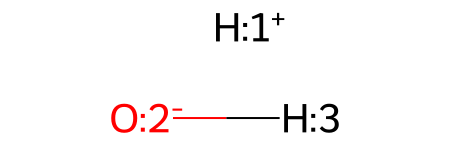

In [31]:
mol_reac = make_mol(reac)
mol_reac

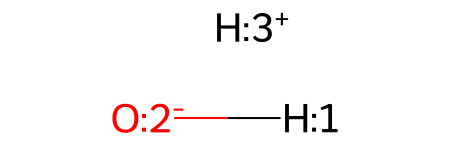

In [32]:
mol_prod = make_mol(prod)
mol_prod

We could now construct two D-MPNNs for reactants and products separately, and then combine them either on the molecular level (disregarding the numbering), or on the atomic level (making use of the numbering).

Side note: On the molecular level, for the reaction above, we cannot even detect a reaction, since the reactants and products are both one H+ and one OH-. Although a reaction occurs from a mechanistic point of view, our model would not see it. So disregarding the numbering is maybe not a great option here.

In our research we found it beneficial to instead make a single graph object for the reaction (instead of two for reactants and products), namely the condensed graph of reaction, where each atom and bond has two feature vectors associated with it, i.e.

atom1[H+,H] --[0,1]-- atom2[O-,O-] --[1,0]-- atom3[H,H+]

which mean that on the reactant side, atom 1 is H+ and has no bond to atom2, but is H and has a bond to atom 2 on the product side, etc.

In the condensed graph of reactions, we will thus use every bond that is either present in the reactants, or products, or both (i.e. modify the list of bonds), and have double the number of atom and bond features (for reactants and products, or e.g. reactants and the differencte between reactants and products):

In [33]:
def map_reac_to_prod(mol_reac, mol_prod):
    prod_map_to_id = dict([(atom.GetAtomMapNum(),atom.GetIdx()) for atom in mol_prod.GetAtoms()])
    reac_id_to_prod_id = dict([(atom.GetIdx(),prod_map_to_id[atom.GetAtomMapNum()]) for atom in mol_reac.GetAtoms()])
    return reac_id_to_prod_id

class RxnGraph:
    def __init__(self, smiles):
        self.smiles_reac, _, self.smiles_prod = smiles.split(">")
        self.f_atoms = []
        self.f_bonds = []
        self.edge_index = []

        params = Chem.SmilesParserParams()
        params.removeHs = False
        mol_reac = Chem.MolFromSmiles(self.smiles_reac,params)
        mol_prod = Chem.MolFromSmiles(self.smiles_prod,params)
        ri2pi = map_reac_to_prod(mol_reac, mol_prod)
        n_atoms = mol_reac.GetNumAtoms()

        for a1 in range(n_atoms):
            f_atom_reac = atom_features(mol_reac.GetAtomWithIdx(a1))
            f_atom_prod = atom_features(mol_prod.GetAtomWithIdx(a1))
            f_atom_diff = [y - x for x, y in zip(f_atom_reac, f_atom_prod)]
            f_atom = f_atom_reac + f_atom_diff
            self.f_atoms.append(f_atom)

            for a2 in range(a1 + 1, n_atoms):
                bond_reac = mol_reac.GetBondBetweenAtoms(a1, a2)
                bond_prod = mol_prod.GetBondBetweenAtoms(ri2pi[a1], ri2pi[a2])
                if bond_reac is None and bond_prod is None:
                    continue
                f_bond_reac = bond_features(bond_reac)
                f_bond_prod = bond_features(bond_prod)
                f_bond_diff = [y - x for x, y in zip(f_bond_reac, f_bond_prod)]
                f_bond = f_bond_reac + f_bond_diff
                self.f_bonds.append(f_bond)
                self.f_bonds.append(f_bond)
                self.edge_index.extend([(a1, a2), (a2, a1)])

Let's inspect the `map_reac_to_prod()` function and the `RxnGraph` class:

In [34]:
map_reac_to_prod(mol_reac, mol_prod)

{0: 0, 1: 1, 2: 2}

In [35]:
g = RxnGraph(smi)
for i,f in enumerate(g.f_atoms):
  print(i,f)
print("")
for (i,j),f in zip(g.edge_index,g.f_bonds):
  print(i,j,f)

0 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0.01008, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]
1 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.15999000000000002, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]
2 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0.01008, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]

0 1 [1, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0]
1 0 [1, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0]
1 2 [0, True, False, False, False, False, False, 1, -1, 0, 0, 0, 0, 0]
2 1 [0, True, False, False, False, False, False, 1, -1, 0, 0, 0, 0, 0]


Nearly done! We only need to add the new RxnGraph option to our `ChemDataset` class:

In [36]:
class ChemDataset(Dataset):
    def __init__(self, smiles, labels, mode='mol'):
        super(ChemDataset, self).__init__()
        self.smiles = smiles
        self.labels = labels
        self.mode = mode

    def process_key(self, key):
        smi = self.smiles[key]
        if self.mode == 'mol':
            molgraph = MolGraph(smi)
        elif self.mode == 'rxn':
            molgraph = RxnGraph(smi)
        else:
            raise ValueError("Unknown option for mode", mode)
        mol = self.molgraph2data(molgraph, key)
        return mol

    def molgraph2data(self, molgraph, key):
        data = tg.data.Data()
        data.x = torch.tensor(molgraph.f_atoms, dtype=torch.float)
        data.edge_index = torch.tensor(molgraph.edge_index, dtype=torch.long).t().contiguous()
        data.edge_attr = torch.tensor(molgraph.f_bonds, dtype=torch.float)
        data.y = torch.tensor([self.labels[key]], dtype=torch.float)
        data.smiles = self.smiles[key]

        return data

    def get(self,key):
        return self.process_key(key)

    def len(self):
        return len(self.smiles)

We are now ready to train our first reaction D-MPNN. We will start with reaction barrier heights for E2 reactions:

In [37]:
train("https://github.com/hesther/rxn_workshop/raw/main/data/e2", mode='rxn')

GNN(
  (edge_init): Linear(in_features=92, out_features=300, bias=True)
  (convs): ModuleList(
    (0-2): 3 x DMPNNConv()
  )
  (edge_to_node): Linear(in_features=378, out_features=300, bias=True)
  (ffn): Linear(in_features=300, out_features=1, bias=True)
)
Epoch 0   Train RMSE 35.774195879436796    Val RMSE 14.513715900654535
Epoch 1   Train RMSE 11.63350440248411    Val RMSE 10.950949172123316
Epoch 2   Train RMSE 10.373750910195277    Val RMSE 10.420874359164841
Epoch 3   Train RMSE 9.720856760200911    Val RMSE 9.77439099649256
Epoch 4   Train RMSE 8.937523048211103    Val RMSE 8.850130785961678
Epoch 5   Train RMSE 7.964656960475252    Val RMSE 7.682383386457789
Epoch 6   Train RMSE 6.788314584989794    Val RMSE 6.571278412022017
Epoch 7   Train RMSE 5.86648819536338    Val RMSE 5.908701182266676
Epoch 8   Train RMSE 5.446279869461714    Val RMSE 5.529385403387518
Epoch 9   Train RMSE 5.0620254482562554    Val RMSE 5.290860337159625
Epoch 10   Train RMSE 4.916838475905481    Val 

Now that's a pretty good performance given we didn't do any hyperparameter optimization, and the model is rather small, and only used very simple features.

Let's also train on SN2 reaction barrier heights:

In [38]:
train("https://github.com/hesther/rxn_workshop/raw/main/data/sn2", mode='rxn')

GNN(
  (edge_init): Linear(in_features=92, out_features=300, bias=True)
  (convs): ModuleList(
    (0-2): 3 x DMPNNConv()
  )
  (edge_to_node): Linear(in_features=378, out_features=300, bias=True)
  (ffn): Linear(in_features=300, out_features=1, bias=True)
)
Epoch 0   Train RMSE 31.339081040902926    Val RMSE 11.32231302280772
Epoch 1   Train RMSE 10.651823763436226    Val RMSE 8.641264147737866
Epoch 2   Train RMSE 7.920333200631979    Val RMSE 6.741124655461196
Epoch 3   Train RMSE 6.407949826885876    Val RMSE 5.929408101246502
Epoch 4   Train RMSE 5.891135924667683    Val RMSE 6.628453368029092
Epoch 5   Train RMSE 5.903887886926418    Val RMSE 5.227213705257636
Epoch 6   Train RMSE 5.23014911475507    Val RMSE 5.4826698654530945
Epoch 7   Train RMSE 5.014431725325823    Val RMSE 5.487097156669833
Epoch 8   Train RMSE 4.96733255381551    Val RMSE 4.658382382598446
Epoch 9   Train RMSE 4.643005171711112    Val RMSE 4.496282753666759
Epoch 10   Train RMSE 4.699844179208274    Val RMS

Now, for a single reaction type, we could have also trained a model only on the reactants with about equal performance. The beauty of the condensed graph of reaction formalisms only surfaces when we turn to datasets of different reaction types. Let's combine the E2 and SN2 databases and train on all reactions simultaneously. That means, that the same reactants (nucleophile and electrophile) can either undergo elimination or substitution, so the products with be different, and of course the barrier heights will be different.

In [39]:
train("https://github.com/hesther/rxn_workshop/raw/main/data/e2sn2", mode='rxn')

GNN(
  (edge_init): Linear(in_features=92, out_features=300, bias=True)
  (convs): ModuleList(
    (0-2): 3 x DMPNNConv()
  )
  (edge_to_node): Linear(in_features=378, out_features=300, bias=True)
  (ffn): Linear(in_features=300, out_features=1, bias=True)
)
Epoch 0   Train RMSE 26.771172531492482    Val RMSE 11.704248939409503
Epoch 1   Train RMSE 10.724507112003337    Val RMSE 9.11377372564133
Epoch 2   Train RMSE 7.92754478632012    Val RMSE 6.6446396851811365
Epoch 3   Train RMSE 6.268784637203349    Val RMSE 5.708071334292034
Epoch 4   Train RMSE 5.5755251855193295    Val RMSE 6.132140925438118
Epoch 5   Train RMSE 5.28592759147525    Val RMSE 4.998217055432537
Epoch 6   Train RMSE 4.863611073780669    Val RMSE 4.9014044101177054
Epoch 7   Train RMSE 4.780465254865735    Val RMSE 5.294594796685161
Epoch 8   Train RMSE 4.571328387695355    Val RMSE 4.654586714351828
Epoch 9   Train RMSE 4.457680389981825    Val RMSE 4.777397667523619
Epoch 10   Train RMSE 4.557694922634961    Val R

Now, if you just want a model and a lot of knobs you can tune, I recommend to not code your own approach like in this workshop, but rely on ready-to-use software solutions. The CGR approach presented here is built into Chemprop, which is open-source, free and easy to use, and comes with a ton of extra functionality. Let's try to reproduce the E2 barrier heights with Chemprop.

Chemprop currently doesn't support loading CSV files from the internet like we handwavingly did above, so we have do download them (they are small, so no worries):

In [40]:
!wget https://github.com/hesther/rxn_workshop/raw/main/data/e2/train_full.csv
!wget https://github.com/hesther/rxn_workshop/raw/main/data/e2/val_full.csv
!wget https://github.com/hesther/rxn_workshop/raw/main/data/e2/test_full.csv

--2023-09-05 12:06:13--  https://github.com/hesther/rxn_workshop/raw/main/data/e2/train_full.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hesther/rxn_workshop/main/data/e2/train_full.csv [following]
--2023-09-05 12:06:13--  https://raw.githubusercontent.com/hesther/rxn_workshop/main/data/e2/train_full.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187844 (183K) [text/plain]
Saving to: ‘train_full.csv’

train_full.csv      100%[===================>] 183.44K  --.-KB/s    in 0.006s  

2023-09-05 12:06:14 (31.6 MB/s) - ‘train_full.csv’ saved [187844/187844]

--2023-09-05 12:06:14--  http

We can run chemprop via the command line (so no reason to make even a single python script):

In [41]:
!chemprop_train --data_path train_full.csv --dataset_type regression --reaction --explicit_h --separate_val_path val_full.csv --separate_test_path test_full.csv --extra_metric mae

Command line
python /usr/local/bin/chemprop_train --data_path train_full.csv --dataset_type regression --reaction --explicit_h --separate_val_path val_full.csv --separate_test_path test_full.csv --extra_metric mae
Args
{'activation': 'ReLU',
 'adding_bond_types': True,
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_constraints': [],
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'atom_targets': [],
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_constraints': [],
 'bond_descriptor_scaling': True,
 'bond_descriptors': None,
 'bond_descriptors_path': None,
 'bond_descriptors_size': 0,
 'bond_features_size': 0,
 'bond_targets': [],
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'constraints

Or run within a python script

In [42]:
import chemprop

arguments = [
            '--data_path', 'train_full.csv',
            '--separate_val_path', 'val_full.csv',
            '--separate_test_path', 'test_full.csv',
            '--dataset_type', 'regression',
            '--reaction',
            '--explicit_h',
            '--save_dir','chemprop_model',
            '--extra_metric', 'mae'
]
args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

Command line
python /usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-c9ebf2da-9e42-458c-9c49-66de886c7c37.json
Args
{'activation': 'ReLU',
 'adding_bond_types': True,
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_constraints': [],
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'atom_targets': [],
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_constraints': [],
 'bond_descriptor_scaling': True,
 'bond_descriptors': None,
 'bond_descriptors_path': None,
 'bond_descriptors_size': 0,
 'bond_features_size': 0,
 'bond_targets': [],
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'constraints_path': None,
 'crossval_index_dir': None,
 '

Chemprop comes with a bunch of useful extra features, such as predicting the uncertainty of the model (via ensembling, mean variance estimation or evidential learning). For example:

In [43]:
arguments = [
            '--data_path', 'train_full.csv',
            '--separate_val_path', 'val_full.csv',
            '--separate_test_path', 'test_full.csv',
            '--dataset_type', 'regression',
            '--reaction',
            '--explicit_h',
            '--ensemble_size','3',
            '--save_dir','chemprop_model',
            '--extra_metric', 'mae'
]
args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

Command line
python /usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-c9ebf2da-9e42-458c-9c49-66de886c7c37.json
Args
{'activation': 'ReLU',
 'adding_bond_types': True,
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_constraints': [],
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'atom_targets': [],
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_constraints': [],
 'bond_descriptor_scaling': True,
 'bond_descriptors': None,
 'bond_descriptors_path': None,
 'bond_descriptors_size': 0,
 'bond_features_size': 0,
 'bond_targets': [],
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'constraints_path': None,
 'crossval_index_dir': None,
 '

In [44]:
arguments = [
    '--test_path', 'test_full.csv',
    '--preds_path', 'preds.csv',
    '--checkpoint_dir', 'chemprop_model',
    '--uncertainty_method', 'ensemble',
    '--calibration_method', 'zscaling',
    '--calibration_path', 'val_full.csv',
    '--regression_calibrator_metric', 'stdev',
    '--calibration_interval_percentile', '95',
    '--evaluation_scores_path', 'chemprop_model/unc_eval_scores.csv'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

Loading training args
Setting molecule featurization parameters to default.
Loading data


264it [00:00, 69175.75it/s]
100%|██████████| 264/264 [00:00<00:00, 53622.09it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validating SMILES
Test size = 264


200it [00:00, 47243.79it/s]
100%|██████████| 200/200 [00:00<00:00, 38877.55it/s]

Loading training args



  0%|          | 0/3 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



 33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



 67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Optimization terminated successfully.
         Current function value: 643.718874
         Iterations: 15
         Function evaluations: 30


  0%|          | 0/3 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



 33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



 67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Saving predictions to preds.csv
Elapsed time = 0:00:09


In [45]:
df = pd.read_csv("preds.csv")
pred = df['ea']
unc = df['ea_ensemble_zscaling_stdev']
true = pd.read_csv("test_full.csv")['ea']

plt.errorbar(true,pred,yerr=unc, fmt="o", alpha=0.5)
plt.plot([0,50],[0,50])
plt.xlabel("E$_a^{True}$ [kcal/mol]")
plt.ylabel("E$_a^{Predicted}$ [kcal/mol]")

In [46]:
plt.scatter(abs(true-pred),unc,alpha=0.5)
plt.plot([0,25],[0,25])
plt.xlabel("|E$_a^{True}$ -E$_a^{Predicted}$|  [kcal/mol]")
plt.ylabel("Epistemic uncertainty [kcal/mol]")

NameError: ignored

Looks quite good (i.e. not a lot of datapoints below the line, where a point below the line indicates the model is overconfident, i.e. the true error is worse than the estimated uncertainty).

# References:

- **Reaction MPNNs via CGRs:**
  - E. Heid, W. H. Green. J. Chem. Inf. Model. 2022, 62, 9, 2101–2110. [DOI:10.1021/acs.jcim.1c00975](https://doi.org/10.1021/acs.jcim.1c00975)
- **Chemprop:**
  - E. Heid, K. P. Greenman, Y. Chung, S.-C. Li, D. E. Graff, F. H. Vermeire, H. Wu, W. H. Green, C. J. McGill. ChemRxiv. DOI: [10.26434/chemrxiv-2023-3zcfl-v2](https://doi.org/10.26434/chemrxiv-2023-3zcfl-v2)
  - K. Yang, K. Swanson, W. Jin, C. Coley, P. Eiden, H. Gao, A. Guzman-Perez, T. Hopper, B. Kelley, M. Mathea, A. Palmer, V. Settels, T. Jaakola, K. Jensen, R. Barzilay. Chem. Inf. Model. 2019, 59, 8, 3370–3388 [DOI:10.1021/acs.jcim.9b00237](https://doi.org/10.1021/acs.jcim.9b00237)